In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Utility functions

In [34]:
def plot_decision_boundary(X, y, clf):
    fig, ax = plt.subplots(figsize=(8,6))
    
    # Create a meshgrid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 0].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    
    # Make a Prediction on every grid point
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.Blues)
    
    # Define markers and colors for each (both) class
    markers = ['o', '^']
    colors = ['black', 'orange']
    labels = np.unique(y)
    
    # Plot the original data (each class with a different marker and color)
    for i, label in enumerate(labels):
        X_sub = X[y == label]
        ax.scatter(X_sub[:, 0], X_sub[:, 1], marker=markers[i], color=colors[i])
    ax.set_xlabel('Petal length (standardized)')
    ax.set_ylabel('Petal width (standardized)')
    ax.set_title('Logistic regression classifier decision boundary')
    plt.tight_layout();

In [26]:
def viz_training_progress(clf):
    log_loss = clf.losses_
    eta = clf.eta
    r = np.arange(1, len(log_loss) + 1)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(r, log_loss, marker='o', zorder=2, markerfacecolor='none', markeredgecolor='black')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss function (log-loss)')
    ax.set_title(f'Learning rate = {eta}')
    ax.grid(True, alpha=0.3, zorder=1);

### The Sigmoid Function

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
x_vals = np.linspace(-5, 5, 1000)

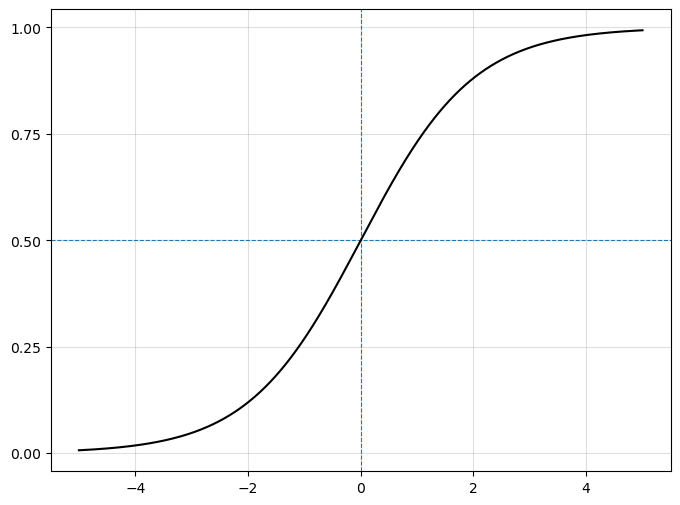

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x_vals, sigmoid(x_vals), color='black', zorder=4)
ax.axhline(y=0.5, linestyle='dashed', linewidth=0.8, zorder=2)
ax.axvline(x=0, linestyle='dashed', linewidth=0.8, zorder=3)
ax.grid(True, alpha=0.4, zorder=1)
ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0]);

### Illustrating the logistic loss function

(See p. 63–65). Create a short code snippet to create a plot that illustrates the loss of classifying a single training example for different values of $\, \sigma(z). \,$

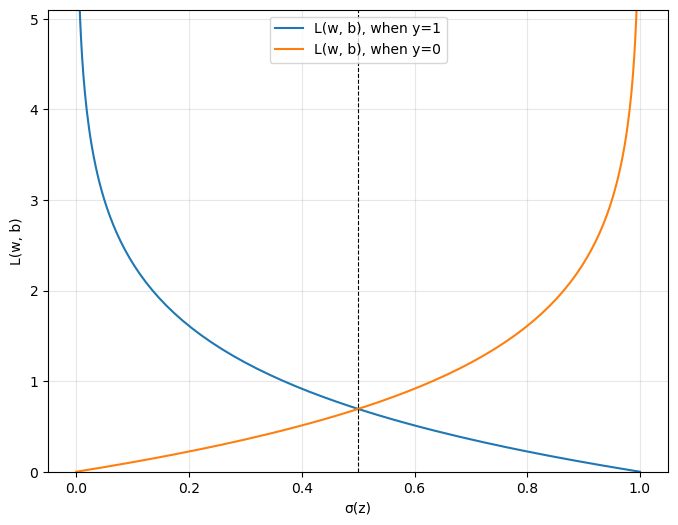

In [7]:
def loss_1(z):
    return -np.log(sigmoid(z))

def loss_0(z):
    return -np.log(1 - sigmoid(z))

z = np.linspace(-10, 10, 200)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
c0 = [loss_0(x) for x in z]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(sigma_z, c1, label='L(w, b), when y=1')
ax.plot(sigma_z, c0, label='L(w, b), when y=0')
ax.axvline(x=0.5, linestyle='dashed', color='black', linewidth=0.8, zorder=2)
ax.set_xlabel('σ(z)')
ax.set_ylabel('L(w, b)')
ax.set_ylim([0.0, 5.1])
ax.grid(True, alpha=0.3, zorder=1)
ax.legend();

The classification rule (threshold function) in logistic regression:

$$
\hat{y} =
\begin{cases}
1, & \text{if } \sigma(z) \ge 0.5 \\
0, & \text{if } \sigma(z) < 0.5
\end{cases}
\quad \text{where} \quad
\sigma(z) = \frac{1}{1 + e^{-z}}
$$


- The loss $\, L(w,b) \,$ approaches zero the "more sure" we are about our classification. That is, the closer $\, \sigma(z) \,$ is to 0 or 1.
- On the other hand, if the classifier predicts, for example, with a probability of $\, 0.8 \,$ that $\, P(y=1|\boldsymbol{x}) \,$ when in reality $\, y=0, \,$ the penalization for that prediction is approx. 1.7.
- Similarly, if the classifier predicts, for example, with a probability of $\, 0.6 \,$ that $\, P(y=1|\boldsymbol{x}) \,$ when in reality $\, y=0, \,$ the penalization for that prediction is only approx 0.95.
- We can see here that the greater mistakes our classifier makes, the more we penalize it.

Summa summaarum:

- More confident **correct** predictions $\;\Rightarrow\;$ loss $\to 0$
- More confident **wrong** predictions $\;\Rightarrow\;$ loss grows rapidly
- Larger mistakes are penalized more than smaller ones

### Logistic Regression Class

In [8]:
class LogisticRegressionGD:
    """
    (Batch) gradient descent based logistic regression classifier.
    
    Parameters
    ----------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset
    random_state : int
      Random number generator seed for random weight initialization
    
    Attributes
    ----------
    w_ : 1D-array
      Weights after fitting (optimization)
    b_ : scalar
      Bias (intercept) after fitting (optimization)
    losses_ : list
      Logistic loss (aka log-loss) function after each epoch
    """
    def __init__(self, eta=0.01, n_iter=5, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
      
    def fit(self, X, y):
        """
        In the notation below, X is assumed to be nxp, and y nx1.
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])  # p x 1
        self.b_ = np.float64(0.0)
        self.losses_ = []
        for i in range(self.n_iter):
            z = self.net_input(X)                            # n x 1
            errors = y - self.activation(z)                  # n x 1
            self.w_ += self.eta * X.T @ errors / X.shape[0]  # p x 1
            self.b_ += self.eta * np.mean(errors)            # 1 x 1
            loss = self.calculate_loss(y, z)
            self.losses_.append(loss)
        return self
     
    def net_input(self, X):
        return X @ self.w_ + self.b_  # n x 1
        # Note that X @ self.w_ is n-dimensional vector and b is a scalar,
        # so NumPy performs broadcasting ==> creates a n-dimensional vector,
        # where each element is b.
    
    def activation(self, z):
        """
        Compute the sigmoid activation.
        """
        return 1.0 / (1.0 + np.exp(-z))  # n x 1
    
    def calculate_loss(self, y, z):
        n = len(y)
        sigma_z = self.activation(z)
        L = -(y.T @ np.log(sigma_z) + (1 - y).T @ np.log(1 - sigma_z)) / n
        return L
    
    def predict(self, X):
        """
        Return a predicted class label via the threshold function.
        """
        z = self.net_input(X)         # n x 1
        sigma_z = self.activation(z)  # n x 1
        return np.where(sigma_z >= 0.5, 1, 0)
    
    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

### Load data

In [9]:
iris = load_iris(as_frame=True)
df = pd.concat([iris.data, iris.target], axis=1)
df = df[df['target'].isin([0, 1])]

In [10]:
X = df[['petal length (cm)', 'petal width (cm)']].values
y = df['target'].values

In [11]:
print(X.shape)
print(y.shape)

(100, 2)
(100,)


### Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(80, 2)
(80,)
(20, 2)
(20,)
(array([0, 1]), array([40, 40]))
(array([0, 1]), array([10, 10]))


### Feature scaling

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model training

In [15]:
log_reg_gd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
log_reg_gd.fit(X_train_scaled, y_train)

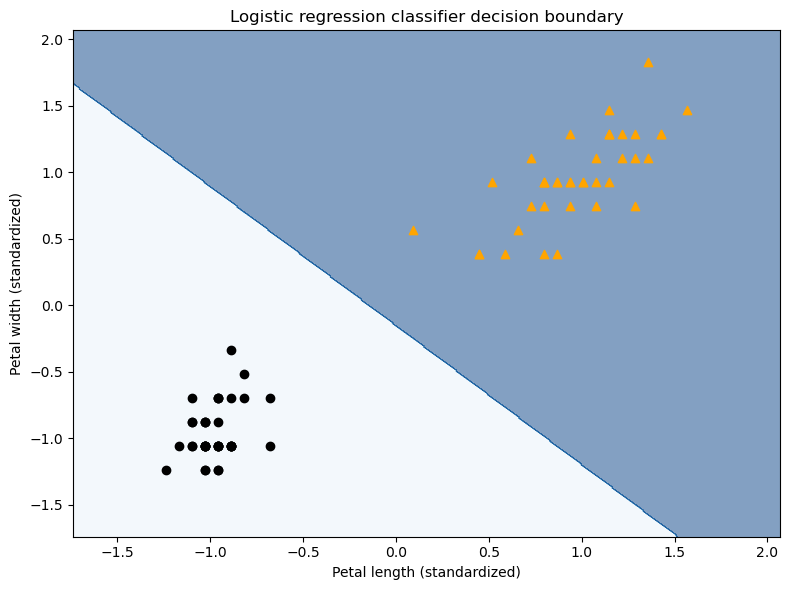

In [35]:
plot_decision_boundary(X=X_train_scaled, y=y_train, clf=log_reg_gd)

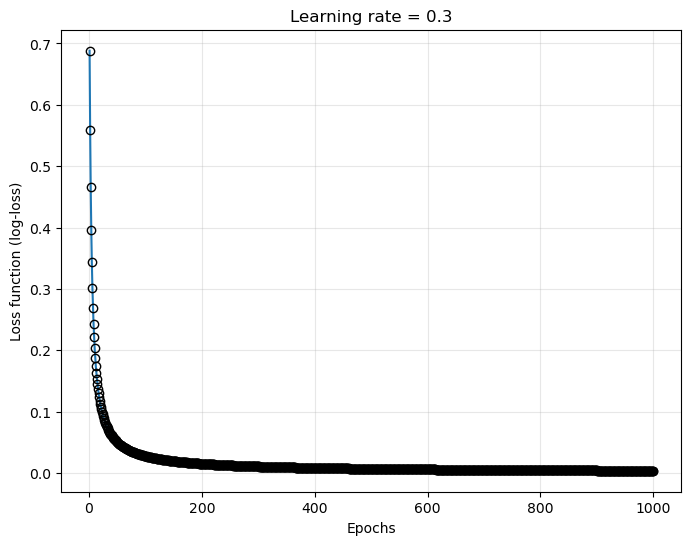

In [36]:
viz_training_progress(clf=log_reg_gd)

### Model evaluation

In [37]:
# Training accuracy
y_pred_train = log_reg_gd.predict(X=X_train_scaled)
training_accuracy = log_reg_gd.accuracy(y_true=y_train, y_pred=y_pred_train)
print(f'Training accuracy over {len(y_train)} samples: {training_accuracy}')

Training accuracy over 80 samples: 1.0


In [38]:
# Test accuracy
y_pred_test = log_reg_gd.predict(X=X_test_scaled)
test_accuracy = log_reg_gd.accuracy(y_true=y_test, y_pred=y_pred_test)
print(f'Test accuracy over {len(y_test)} samples: {test_accuracy}')

Test accuracy over 20 samples: 1.0
